# MinimizingEFT

This script runs the various algorithms for creating χ<sup>2</sup> models and minimizing these for multiple models.


<b> NB: this script takes a little while to run to be patient </b>

## Load in py functions within directory

In [ ]:
# %load EFT.py
import numpy as np
import math
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

class EFT(object):

    # Initial conditions for the universe. 
    def __init__(self, omega_m, omega_phi, H0, a0, t0, iterations, dt):
        self.omega_m = omega_m
        self.omega_phi = omega_phi
        self.dt = dt
        self.H0 = H0
        self.a0 = a0
        self.it = iterations
        self.t = np.arange(t0, t0 + iterations*dt, dt) 
        
   # Concordence model: inferred solution for Lambda-CDM.
    def BackgroundTheory(self):
        avals, Hvals, Hdot= [], [], []
        anext, H = self.a0, self.H0
        for i in range(len(self.t)):
            avals.append(anext)
            Hvals.append(H)
            brack = (self.omega_m)*(math.pow(anext,-3)) + self.omega_phi
            H2 = (math.pow(self.H0, 2))*brack
            H = math.sqrt(H2)
            anext = anext*(1 + H*self.dt)
        return avals, Hvals, Hdot




In [ ]:
# %load ChiSq.py
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib.image as mpimg

class chiSq(object):

    def __init__(self, data, t, H0, a0, t0, Om, Ophi, dt, Lambda0, beta):
        self.dat = data
        self.t = t
        self.Lambda0, self.beta = Lambda0, beta
        self.avals, self.Hvals, self.Hdot, self.Omega, self.Lambda= [], [], [], [], []
        self.avals.append(a0)
        self.anext = a0
        self.H = H0
        self.Gamma = 0.
        self.Hvals.append(H0)
        self.chivals, self.params1, self.params2 = [], [], []
        self.Hdot.append(0.)
        self.dt = dt
        self.H0, self.a0, self.t0, self.Om, self.Ophi = H0, a0, t0, Om, Ophi

    def __call__(self, params):
        D = []
        ypred = self.function(params)[0]  # predicted value from fitted function.
        for i in range(len(ypred)):
            arg = (math.pow((ypred[i] - self.dat[i]), 2))/self.dat[i]
            D.append(arg) # error
        chi = sum(D)
        self.chivals.append(chi)
        self.params1.append(params[0])
        self.params2.append(params[1])
        return chi

    def HOmega(self, ai, H, i, params):
        alpha, OM0 = params[0], params[1]
        Lambda0, beta = self.Lambda0, self.beta
        OM = OM0*(math.pow(self.t[i]/self.t0, alpha))
        OMprime = OM0*(alpha)*(math.pow(self.t[i]/self.t0, alpha - 1))/self.t0
        L = Lambda0*(math.pow(self.t[i]/self.t0, beta))
        term1 = math.pow(self.H0, 2)*self.Om*(math.pow(ai,-3))/(OM)
        term2 = L/(3*OM)
        term3 = H*OMprime/OM
        term4 = self.Gamma/(3*OM)
        H2 = term1 - term2 - term3 + term4
        H = math.sqrt(abs(H2))
        return H, OM, L

    def HLambda(self, ai, H, i, params):
        beta, L0 = params[0], params[1]
        OM0, alpha = 1., 0.
        OM = OM0*(math.pow(self.t[i]/self.t0, alpha))
        OMprime = OM0*(alpha)*(math.pow(self.t[i]/self.t0, alpha - 1))/self.t0
        L = L0*(math.pow(self.t[i]/self.t0, beta))
        term1 = math.pow(self.H0, 2)*self.Om*(math.pow(ai,-3))/(OM)
        term2 = L/(3*OM)
        term3 = H*OMprime/OM
        term4 = self.Gamma/(3*OM)
        H2 = term1 - term2 - term3 + term4
        H = math.sqrt(abs(H2))
        return H, OM, L

    def HGamma(self, ai, H, i, params):
        delta, G0 = params[0], params[1]
        OM0, alpha, L0, beta = 1., 0., self.Lambda0, self.beta
        OM = OM0*(math.pow(self.t[i]/self.t0, alpha))
        OMprime = OM0*(alpha)*(math.pow(self.t[i]/self.t0, alpha - 1))/self.t0
        L = L0*(math.pow(self.t[i]/self.t0, beta))
        Gamma = G0*(math.pow(self.t[i]/self.t0, delta) )
        term1 = math.pow(self.H0, 2)*self.Om*(math.pow(ai,-3))/(OM)
        term2 = L/(3*OM)
        term3 = H*OMprime/OM
        term4 = Gamma/(3*OM)
        H2 = term1 - term2 - term3 + term4
        H = math.sqrt(abs(H2))
        return H, OM, L

    def function(self, params):
        avals, Hvals, Hdot, Omega, Lambda= [], [], [], [], []
        anext, H = self.a0, self.H0
        for i in range(len(self.t)):
            avals.append(anext)
            Hvals.append(H)
            val = i
              #temp = self.HOmega(anext, H, val, params)
            temp = self.HLambda(anext, H, val, params)
            #temp = self.HOmega(anext, H, val, params)
            H, OM, L = temp[0], temp[1], temp[2]
            Omega.append(OM)
            Lambda.append(L)
            atemp = anext*(1 + H*self.dt)
            Hdot.append((H - Hvals[i-1])/self.dt)
            anext = anext*(1 + H*self.dt)
        return avals, Hvals, Hdot, Omega, Lambda

    def check(self):
        i = self.chivals.index(min(self.chivals))
        print(self.chivals[i])
        scaledchi, scaledalpha, scaledomo = [], [], []
        for j in range(len(self.chivals)):
            if self.chivals[j] <= 0.5:
                scaledchi.append(self.chivals[j])
                scaledalpha.append(self.params1[j])
                scaledomo.append(self.params2[j])
        plt.scatter(scaledalpha, scaledomo, c=scaledchi)
        plt.colorbar(label = r'$\chi^2$')
        plt.xlabel(r'$\alpha$')
        plt.ylabel(r'$\Omega_0$')
        plt.xlim([-3,3])
        plt.ylim([-3,3])
        plt.plot(0,1, marker = '*', color = 'm', markersize = 15)
        plt.title(r'$\chi^2$ for parameters $\alpha$ and $\Omega_0$')
        plt.show()


In [ ]:
# %load ChiSq4params.py
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib.image as mpimg

class ChiSq4params(object):

    def __init__(self, data, t, H0, a0, t0, Om, Ophi, dt):
        self.dat = data
        self.t = t
        self.avals, self.Hvals, self.Hdot, self.Omega, self.Lambda= [], [], [], [], []
        self.avals.append(a0)
        self.anext = a0
        self.H = H0
        self.Hvals.append(H0)
        self.chivals, self.params1, self.params2,  self.params3, self.params4 = [], [], [], [], []
        self.Hdot.append(0.)       
        self.dt = dt
        self.H0, self.a0, self.t0, self.Om, self.Ophi = H0, a0, t0, Om, Ophi

    def __call__(self, params):
        D = []
        ypred = self.function(params)[0]  # predicted value from fitted function. 
        for i in range(len(ypred)):
            arg = (math.pow((ypred[i] - self.dat[i]), 2))/self.dat[i]
            D.append(arg) # error
        chi = sum(D)
        self.chivals.append(chi)
        self.params1.append(params[0])
        self.params2.append(params[1])
        self.params3.append(params[2])
        self.params4.append(params[3])
        return chi

    def Hubble(self, ai, H, i, params):
        alpha, OM0, beta, L0 = params[0], params[1],  params[2], params[3]
        OM = OM0*(math.pow(self.t[i]/self.t0, alpha))
        if OM ==0: OM = -0.00001
        OMprime = OM0*(alpha)*(math.pow(self.t[i]/self.t0, alpha - 1))/self.t0
        L = L0*(math.pow(self.t[i]/self.t0, beta))
        term1 = math.pow(self.H0, 2)*self.Om*(math.pow(ai,-3))/(OM)
        term2 = L/(3*OM)
        term3 = H*OMprime/OM
        H2 = term1 - term2 - term3
        H = math.sqrt(abs(H2))
        return H, OM, L

    def function(self, params):
        avals, Hvals, Hdot, Omega, Lambda= [], [], [], [], []
        anext, H = self.a0, self.H0
        for i in range(len(self.t)):
            avals.append(anext)
            Hvals.append(H)
            val = i
            temp = self.Hubble(anext, H, val, params)
            H, OM, L = temp[0], temp[1], temp[2]
            Omega.append(OM)
            Lambda.append(L)
            atemp = anext*(1 + H*self.dt)
            Hdot.append((H - Hvals[i-1])/self.dt)
            anext = anext*(1 + H*self.dt)
        return avals, Hvals, Hdot, Omega, Lambda

    def check(self):
        val = min(n for n in self.chivals if n!=min(self.chivals))
        i = self.chivals.index(val)
        altparams = [self.params1[i], self.params2[i], self.params3[i], self.params4[i]]
        print(altparams, self.chivals[i])
        return altparams
        
    


In [ ]:
from scipy.optimize import minimize

## Set up parameters

Define the parameters you are fitting. c defines which set of parameters to use in your model.

|c   | parameters |
|--|----------|
|2| Om, alpha | 
|3| L0, beta |
|4| all four |

In [ ]:
c = 3

The parameters themselves:

In [ ]:
Om, Ophi, m0 =  0.3, 0.7, 8*math.pi*6.67E-11
a0, H0, t0, dt, it= 0.15, 1/13.7, 1., 0.001, 2000
OM0, Lambda0, beta = 1., -1*math.pow(H0, 2)*Ophi*3, 0.

# Set the time
t = np.arange(t0, t0 + it*dt, dt)

### Model the EFT and χ<sup>2</sup>

In [ ]:
Eft = EFT(Om, Ophi, H0, a0, t0, it, dt)
data = Eft.BackgroundTheory()[0]
chi1 = chiSq(data, t, H0, a0, t0, Om, Ophi, dt, Lambda0, beta)
chi2 = chiSq(data, t, H0, a0, t0, Om, Ophi, dt, Lambda0, beta)
chi4 = ChiSq4params(data, t, H0, a0, t0, Om, Ophi, dt)

## Chose model from parameters

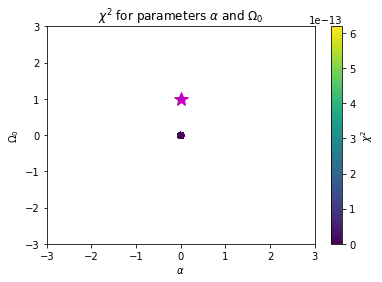

-1.0
couldn't manage  0 0
couldn't manage  0 4
couldn't manage  0 8
couldn't manage  0 9
couldn't manage  0 14
-0.9
couldn't manage  1 2
couldn't manage  1 7
couldn't manage  1 17
-0.8
couldn't manage  2 3
couldn't manage  2 6
couldn't manage  2 9
couldn't manage  2 10
couldn't manage  2 13
couldn't manage  2 15
couldn't manage  2 18
-0.7000000000000001
couldn't manage  3 10
couldn't manage  3 14
couldn't manage  3 16
couldn't manage  3 17
-0.6000000000000001
-0.5000000000000001
-0.40000000000000013
-0.30000000000000016
-0.20000000000000018
-0.1000000000000002
-2.220446049250313e-16
0.09999999999999964
0.19999999999999973
0.2999999999999998
couldn't manage  13 5
0.3999999999999997
couldn't manage  14 15
couldn't manage  14 16
0.49999999999999956
couldn't manage  15 5
couldn't manage  15 16
0.5999999999999996
couldn't manage  16 15
couldn't manage  16 16
couldn't manage  16 17
couldn't manage  16 18
couldn't manage  16 19
0.6999999999999997
couldn't manage  17 14
couldn't manage  17 16


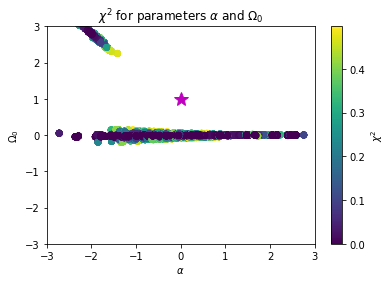

In [44]:
if c ==2:
    theoryfun = chi1.function([0., OM0])
    madeupfun = chi1.function([1.5, 3.])
    value = minimize(chi1, [0., OM0], method = 'TNC', tol = 0.000001, bounds = ((-3, 3), (-3, 3)))
    chi1.check()
    # Finding chi over alpha, omega space.
    alphainits, om0inits = np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1)
    for i in range(len(alphainits)):
        print(alphainits[i])
        for j in range(len(om0inits)):
            try: value2 = minimize(chi2, [alphainits[i], om0inits[j]], method = 'TNC')
            except OverflowError: print("couldn't manage ", i, j)
    chi2.check()

if c ==3:
    theoryfun = chi1.function([0., Lambda0])
    value = minimize(chi1, [0., Lambda0], method = 'TNC', tol = 0.000001, bounds = ((-3, 3), (-3, 3)))
    chi1.check()
    # Finding chi over beta, Lambda space.
    betainits, L0inits = np.arange(-1, 1, 0.1), np.arange(-1, 1, 0.1)
    for i in range(len(betainits)):
        print(betainits[i])
        for j in range(len(L0inits)):
            try:value2 = minimize(chi2, [betainits[i], L0inits[j]], method = 'TNC')
            except OverflowError: print("couldn't manage ", i, j)
    chi2.check()

if c ==5:
    theoryfun = chi1.function([0., 0.])
    value = minimize(chi1, [0., 0.], method = 'TNC', tol = 0.000001, bounds = ((-3, 3), (-3, 3)))
    chi1.check()
    # Finding chi over beta, Lambda space.
    lambdainits, G0inits = np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1)
    for i in range(len(lambdainits)):
        print(lambdainits[i])
        for j in range(len(G0inits)):
            try: value2 = minimize(chi2, [lambdainits[i], G0inits[j]], method = 'TNC', bounds=((-5, 5), (-5, 5)))
            except OverflowError as er: print("couldn't manage", i, j)
    chi2.check()

if c==4 :
    theoryfun = chi4.function([0., OM0, 0., Lambda0])
    value = minimize(chi4, [0., OM0, 0., Lambda0], method = 'TNC', tol = 0.000001)
    altparams = chi4.check()
    altfun = chi4.function(altparams)

# How did it go?

In [45]:
print('Success?: ', value.success, value.message)
if c==2: print('The minimised alpha = ', value.x[0],  ', \t Omega0 = ', value.x[1])
if c==3: print('The minimised beta = ', value.x[0],  ', \t Lambda0 = ', value.x[1])
if c==5: print('The minimised delta = ', value.x[0],  ', \t Gamma0 = ', value.x[1])
if c==4: print('beta = ', value.x[2],  ', \t Lambda0= ', value.x[3])
print('The minimised chi^2 = ', value.fun)
if c==2 or c==3 or c==5: new = chi1.function(value.x)
if c==4: new = chi4.function(value.x)

Success?:  False Linear search failed
The minimised beta =  0.0 , 	 Lambda0 =  -0.011188662155682243
The minimised chi^2 =  0.0


# Plot the functions

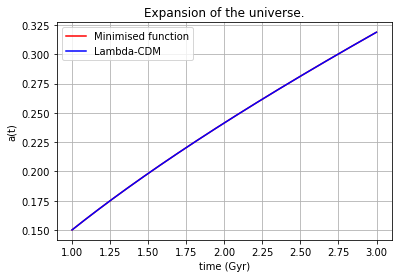

In [47]:
plt.plot(t, new[0], 'r', label = 'Minimised function')
#plt.plot(t, madeupfun[0], 'g', label = 'alpha = 0, beta = 0, Lambda = 0.7')
plt.plot(t, data, 'b', label = 'Lambda-CDM')
if c ==4: plt.plot(t, altfun[0])
plt.legend(loc = 2)
plt.title('Expansion of the universe.')
plt.ylabel('a(t)')
plt.xlabel('time (Gyr)')
plt.grid(True)
plt.show()